In [21]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import sys
sys.path.append("..")
from functions.functions_analysis import *

# Import data

In [45]:
sumtable = pd.read_excel("../../data/summary_table_all.xlsx")
sumtable.drop('Unnamed: 0', axis = 1,inplace = True)

scraped_data = pd.read_csv("../../data/data_from_scrapy.csv")

#length
len(sumtable),len(scraped_data)

(5771, 5771)

In [42]:
scraped_data.head(3)

,case_brief,case_name,case_status,class_period_end,class_period_start,company_market,court,date_filed,date_of_last_review,docket,...,fic_links_list,fic_summary_table,headquarters,industry,judge,market_status,plaintiffs,sector,ticker_symbol,url
0,"According to the Complaint, Wirecard is a tech...",Wirecard AG Securities Litigation,ONGOING,6/24/20,8/17/15,OTC-BB,E.D. Pennsylvania,7/7/20,7/8/20,20-CV-03326,...,http://securities.stanford.edu/filings-documen...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",Germany,Software & Programming,Hon. ANITA B. BRODY,Public (Listed),"The Rosen Law Firm, P.A. (Jenkintown)",Technology,WCAGY,http://securities.stanford.edu/filings-case.ht...
1,"According to the Complaint, Finjan Holdings, I...","Finjan Holdings, Inc. Securities Litigation",ONGOING,6/29/20,6/10/20,NASDAQ,N.D. California,6/29/20,6/30/20,20-CV-04289,...,http://securities.stanford.edu/filings-documen...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",United States,Software & Programming,Hon. Edward M. Chen,Public (Listed),"Brodsky & Smith, LLC (California)",Technology,FNJN,http://securities.stanford.edu/filings-case.ht...
2,"According to the Complaint, Chembio Diagnostic...","Chembio Diagnostics, Inc. Securities Litigation",ONGOING,7/1/20,6/16/20,NASDAQ,E.D. New York,7/1/20,7/3/20,20-CV-02918,...,http://securities.stanford.edu/filings-documen...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",United States,Biotechnology & Drugs,Hon. Sandra J. Feuerstein,Public (Listed),Fields Kupka & Shukurov LLP\n\t\t\t\t\t\t\t\t\...,Healthcare,CEMI,http://securities.stanford.edu/filings-case.ht...


# Data Prepossing

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

In [55]:
sumtable["case_id"] = sumtable.index
scraped_data["case_id"] = data_input.index

In [57]:
scraped_data.head(2)

,case_brief,case_name,case_status,class_period_end,class_period_start,company_market,court,date_filed,date_of_last_review,docket,...,fic_summary_table,headquarters,industry,judge,market_status,plaintiffs,sector,ticker_symbol,url,case_id
0,"According to the Complaint, Wirecard is a tech...",Wirecard AG Securities Litigation,ONGOING,6/24/20,8/17/15,OTC-BB,E.D. Pennsylvania,7/7/20,7/8/20,20-CV-03326,...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",Germany,Software & Programming,Hon. ANITA B. BRODY,Public (Listed),"The Rosen Law Firm, P.A. (Jenkintown)",Technology,WCAGY,http://securities.stanford.edu/filings-case.ht...,0
1,"According to the Complaint, Finjan Holdings, I...","Finjan Holdings, Inc. Securities Litigation",ONGOING,6/29/20,6/10/20,NASDAQ,N.D. California,6/29/20,6/30/20,20-CV-04289,...,"{""No"":{""0"":""1"",""1"":""2""},""Document Title"":{""0"":...",United States,Software & Programming,Hon. Edward M. Chen,Public (Listed),"Brodsky & Smith, LLC (California)",Technology,FNJN,http://securities.stanford.edu/filings-case.ht...,1


In [67]:
scraped_data.columns

Index(['case_brief', 'case_name', 'case_status', 'class_period_end',
       'class_period_start', 'company_market', 'court', 'date_filed',
       'date_of_last_review', 'docket', 'fic_doc_links', 'fic_links_list',
       'fic_summary_table', 'headquarters', 'industry', 'judge',
       'market_status', 'plaintiffs', 'sector', 'ticker_symbol', 'url',
       'case_id'],
      dtype='object')

## Subsetting to data with no NA values

In [125]:
#subset the data to features needed
noNA = ["case_brief",
        "case_id",
        "case_status",
        "class_period_end",
        "class_period_start",
        "company_market",
        "court",
        "date_filed",
        "headquarters",
        "industry",
        "judge",
        "market_status",
        "sector"]

def subsetting(data):
    data = data.dropna(subset=noNA)
    data = data[data["case_status"]!="ONGOING"]
    return data

data = subsetting(scraped_data)

## Exchange, duration, time

In [126]:
#add Concrete Exchange Information (company_market only listed primary)
def findExchange(ticker):
    return sumtable["Exchange"][sumtable["Ticker"]==ticker].unique()

def preprocessExchange(data):
    data["exchange"]=data["ticker_symbol"].apply(lambda x: findExchange(x))
    return data

In [127]:
#calculate duration
from datetime import timezone 
import datetime

def preprocessTime(data):
    data["class_period_start"] = pd.to_datetime(data["class_period_start"])
    data["class_period_end"] = pd.to_datetime(data["class_period_end"])
    data["date_filed"] = pd.to_datetime(data["date_filed"])
    data["class_duration"] = data["class_period_end"] - data["class_period_start"]
    
    data["class_period_end_num"] = data["class_period_end"].apply(lambda x:x.replace(tzinfo = timezone.utc).timestamp())
    data["class_period_start_num"] = data["class_period_start"].apply(lambda x:x.replace(tzinfo = timezone.utc).timestamp())
    data["date_filed_num"] = data["date_filed"].apply(lambda x:x.replace(tzinfo = timezone.utc).timestamp())
    data["class_duration_num"] = data["class_period_end_num"]-data["class_period_start_num"]
    return data

In [128]:
#preprocess and remove ongoing cases and remove judge as a feature
def preprocessAll(data):
    data_input= preprocessExchange(data)
    data_input= preprocessTime(data_input)
    return data

data_input = preprocessAll(data)

In [129]:
data_input.columns

Index(['case_brief', 'case_name', 'case_status', 'class_period_end',
       'class_period_start', 'company_market', 'court', 'date_filed',
       'date_of_last_review', 'docket', 'fic_doc_links', 'fic_links_list',
       'fic_summary_table', 'headquarters', 'industry', 'judge',
       'market_status', 'plaintiffs', 'sector', 'ticker_symbol', 'url',
       'case_id', 'exchange', 'class_duration', 'class_period_end_num',
       'class_period_start_num', 'date_filed_num', 'class_duration_num'],
      dtype='object')

## Construct X and Y

In [130]:
##creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

##identify columns
category_columns = ["company_market","court","headquarters","industry","market_status"]#,"sector"]

##fit encoder and transfrom
enc.fit(data_input[category_columns].values)
X_onehot = enc.transform(data_input[category_columns].values).toarray() #enc.get_feature_names(category_columns)

In [132]:
##get other vars for X
X_time = data_input[["class_period_end_num",
                    "class_period_start_num",
                    "date_filed_num",
                    "class_duration_num"]].values

def time_norm(x_time):
    normalized = np.zeros(shape=(X_time.shape[0],1))
    for i in range(x_time.shape[1]):
        f = np.take(x_time,[i],1)
        f = (f- np.min(f))/np.std(f)
        #print(normalized.shape,f.shape)
        normalized = np.concatenate((normalized,f),1)
    
    normalized = np.delete(normalized,[0],1)
    return normalized
        
X = np.concatenate((time_norm(X_time), X_onehot),1)

##TODO: add constant ones?

In [173]:
## construct y
y_raw=data_input['case_status'].values
y=np.zeros(y_raw.shape)
y[rawy=="DISMISSED"]=1
y=y.reshape(-1,1)

In [174]:
X.shape,y.shape

((5061, 266), (5061, 1))

In [176]:
sum(y==1), sum(y==0) #relatively balanced data

(array([2567]), array([2494]))

## Train test split

In [177]:
#create cross validation sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=777)
X_ttrain, X_tval, y_ttrain, y_tval = train_test_split(X_train, y_train, test_size=0.20, random_state=888)

In [178]:
len(X_ttrain),len(X_tval),len(X_test)

(2833, 709, 1519)

# Model Functions

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import json

In [188]:
def modelEval(X_train, y_train, X_test, y_test, model, result_output_name, path = "../model_results/", printResults = True):
    clf = model.fit(X_train, y_train)
    
    # predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
#     print(y_pred_train.shape, y_train.shape)
#     assert(y_pred_train.shape == y_train.shape)
#     assert(y_pred_test.shape == y_test.shape)
    
    # save results in dictionary
    model_dict = {}
    model_dict['train accuracy'] = clf.score(X_train, y_train)
    model_dict['test accuracy'] = clf.score(X_test, y_test)
    model_dict['train f-score'] = f1_score(y_train, y_pred_train)
    model_dict['test f-score'] = f1_score(y_test, y_pred_test)
    
    # output the dictionary
    with open(path + result_output_name + ".json", "w") as outfile:  
        json.dump(model_dict, outfile) 
    
    # print
    if printResults == True:
        print('train accuracy:', model_dict['train accuracy'])
        print('test accuracy:', model_dict['test accuracy'])
        print('train f-score:', model_dict['train f-score'])
        print('test f-score:', model_dict['test f-score'])
    
    return clf, model_dict

# Decistion Tree

In [181]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [189]:
# cross validation
def crossValidationDT(X_train, y_train, hyperparameters, title):
    scores = []
    for h in hyperparameters:
        model = tree.DecisionTreeClassifier(max_depth=h) #penalty='elasticnet', solver="saga", l1_ratio = 0.3)
        scores.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10).mean())
    
    plt.plot(hyperparameters,scoresDT)
    plt.title(title)
    plt.show()
    return scores

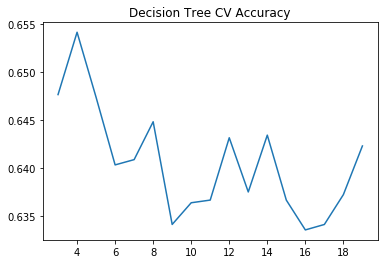

In [190]:
scoresDT = crossValidationDT(X_train, y_train, range(3,20), "Decision Tree CV Accuracy")

In [191]:
# define dt model
dt = tree.DecisionTreeClassifier(max_depth=4)
modeldt = modelEval(X_train, y_train, X_test, y_test, dt, "dt")

train accuracy: 0.6677018633540373
test accuracy: 0.6550362080315998
train f-score: 0.5619650167473019
test f-score: 0.5683690280065897


# Gradient Tree Boosting